Abacus cosmologies:
https://abacussummit.readthedocs.io/en/latest/cosmologies.html

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '/Users/mehdi/Downloads/github/bispectrum')

import numpy as np
import matplotlib.pyplot as plt

from cosmoprimo import Fourier, Cosmology, PowerSpectrumBAOFilter, fiducial
from scipy.optimize import minimize
from src.temp import tree_level_b00, Bi0
import src.utils as ut
from cosmoprimo import PowerSpectrumInterpolator1D
from scipy.interpolate import interp1d

In [4]:
plt.rc('font', family='Times', size=15)
plt.rc('figure', figsize=(8, 6))

In [4]:
bs = ut.get_bispectra('LRGz0')
ps = ut.get_powerspectra('LRGz0')

# k1, k2, k3 = bs.k[700:, :].T
# b_obs = bs.b[:, 700:].mean(axis=0)

k1, k2, k3 = bs.k[:, :].T
b_obs = bs.b[:, :].mean(axis=0)

tracer: LRGz0
tracer: LRGz0


In [5]:
# include RSD in the power spectrum template
len(fiducial.AbacusSummit_params())

98

In [6]:
def loss(params, pk_temp=None):    
    f, b1, b2, s0, s1 = params
    b00 = tree_level_b00(k1, k2, k3, f, b1, b2, s0, s1, pk_temp)    
    return (((k1*k2*k3*k1*k2*k3)*(b00 - b_obs))**2).sum()


engine = 'camb'

for cosmology_id in range(98):

    # cosmo = Cosmology(engine=engine, **dict(Omega0_m=0.32, kmax_pk=101.))
    cosmo = Cosmology(engine=engine, **fiducial.AbacusSummit_params()[cosmology_id])

    fo = Fourier(cosmo, engine=engine)
    pk_temp = fo.pk_interpolator()
    pknow_wallish = PowerSpectrumBAOFilter(pk_temp, engine='wallish2018').smooth_pk_interpolator()

    res = minimize(loss, [1.2, 1.3, 1.1, 0.1, 0.02], method='Powell', args=(pk_temp))
    b00_lado = tree_level_b00(k1, k2, k3, *res.x, pk_temp)
    b00_lado_s = tree_level_b00(k1, k2, k3, *res.x, pknow_wallish)

    np.savetxt(f'BK_bao_only_{cosmology_id}.txt', 
               np.column_stack([bs.k, b00_lado/b00_lado_s]))
    
    print('.', end='')

..................................................................................................

In [7]:
from glob import glob

In [16]:
mocks = np.sort(glob('BK_bao_only_*.txt'))
mocks[:2]

array(['BK_bao_only_0.txt', 'BK_bao_only_1.txt'], dtype='<U18')

(0.8, 1.2)

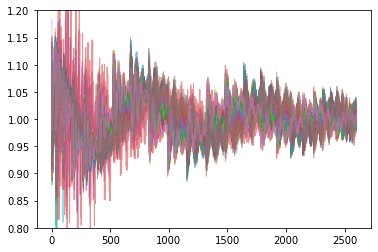

In [18]:
for m in mocks:
    d = np.loadtxt(m)
    plt.plot(d[:, -1], lw=1, alpha=0.5)
plt.ylim(0.8, 1.2)

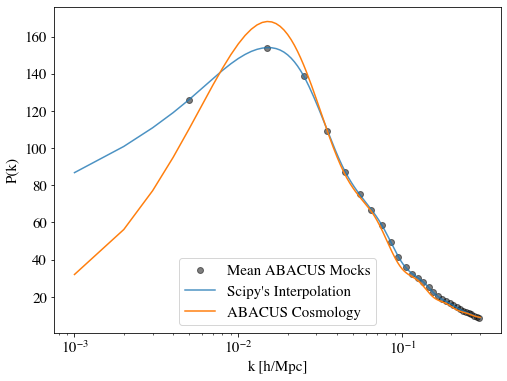

In [10]:
kg = np.linspace(0.001, 0.3, num=300)

plt.scatter(ps.k, ps.p.mean(axis=0), label="Mean ABACUS Mocks", marker='o', color='k', alpha=0.5)
plt.plot(kg, pk_mock(kg), label="Scipy's Interpolation", alpha=0.8)
plt.plot(kg, pk(kg, 0)/1.62e2 + 4, label="ABACUS Cosmology")

plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k)')
plt.semilogx()
plt.legend()

Text(0, 0.5, 'B00')

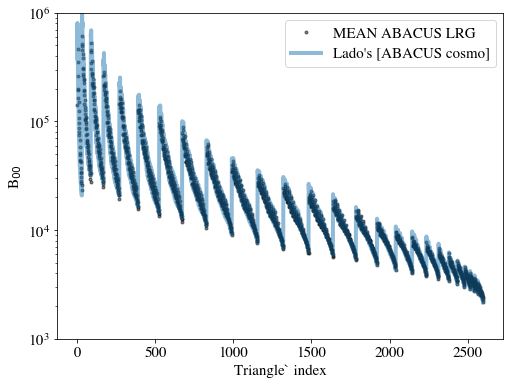

<Figure size 576x432 with 0 Axes>

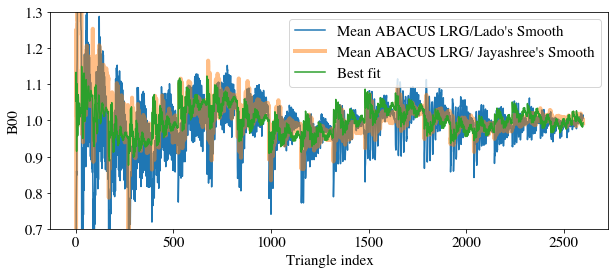

In [14]:
plt.figure(figsize=(8, 6))
plt.axes(yscale='log', ylim=(1.0e3, 1.0e6),
        ylabel=r'B$_{00}$', xlabel='Triangle` index')

plt.plot(b_obs, label='MEAN ABACUS LRG', marker='.', ls='None', alpha=0.5, color='k')
plt.plot(b00_lado, label="Lado's [ABACUS cosmo]", lw=4, alpha=0.5)
plt.legend()

plt.figure()
plt.figure(figsize=(10, 4))
plt.plot(b_obs/b00_lado_s, label="Mean ABACUS LRG/Lado's Smooth")
plt.plot(b_obs/bs.b_smooth.mean(axis=0), label="Mean ABACUS LRG/ Jayashree's Smooth", alpha=0.5, lw=4)
plt.plot(b00_lado/b00_lado_s, label='Best fit')
plt.ylim(0.7, 1.3)
plt.legend()
plt.xlabel('Triangle index')
plt.ylabel('B00')

array([[0.005     , 0.005     , 0.005     , 1.052902  ],
       [0.005     , 0.015     , 0.015     , 1.13238772],
       [0.005     , 0.025     , 0.025     , 1.05438217],
       ...,
       [0.285     , 0.285     , 0.295     , 0.98542163],
       [0.285     , 0.295     , 0.295     , 0.98953391],
       [0.295     , 0.295     , 0.295     , 0.99376333]])

In [49]:
bk_lado = np.loadtxt('BK_bao_only.txt')
bk_lado.shape

(4, 2600)

In [51]:
bk_lado[:, :2].T

array([[0.005     , 0.005     , 0.005     , 2.47840668],
       [0.005     , 0.015     , 0.015     , 1.62963586]])

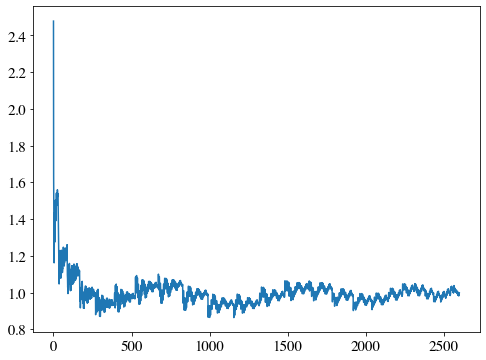

In [29]:
from src.utils import bin_bispectrum

In [33]:
kb, bb = bin_bispectrum(bs.k, b_obs)
__, bbs_true = bin_bispectrum(bs.k, b00_lado_s)
# __, bbsj = bin_bispectrum(bs.k, )

(0.89, 1.11)

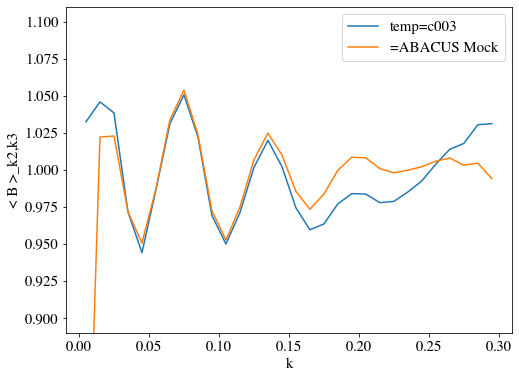

In [36]:
plt.plot(kb, bb/bbs, label='temp=c003')
plt.plot(kb, bb/bbs_true, label='=ABACUS Mock')
plt.legend()
plt.xlabel('k')
plt.ylabel('< B >_k2,k3')
plt.ylim(0.89, 1.11)

In [ ]:
# res_mock = minimize(loss, [1.2, 1.3, 1.1, 0.1, 0.02], method='Powell', args=(pk_1d_mock))#, method='Powell')
# res_smooth = minimize(loss_smooth, [1.2, 1.3, 1.1, 0.1, 0.02], method='Powell')#, method='Powell')

# jb = [ 6.39831982e-03 , 1.05501348e+00 , 1.49932843e+00 , 8.72775638e+02, -1.53462242e+01]
# ld = [-1.44919566, 1.10827374, 4.39491818, -980.75573298, 65.87697057]

# # Y00=np.sqrt(1/np.pi)


# b00_jay = Bi0(k1, k2, k3, *res.x, pk_1d)
# # b00_lado_mock = tree_level_b00(k1, k2, k3, *res_mock.x, pk_1d_mock)
# b00_lado_s = tree_level_b00(k1, k2, k3, *res.x, pknow_1d)
# b00_jay_jb = Bi0(k1, k2, k3, *jb, pk_1d_int)
# b00_jay_ld = Bi0(k1, k2, k3, *ld, pk_1d_int)


# plt.plot(b00_jay_jb, label='Jayashree', ls='-', alpha=0.6)
# plt.plot(b00_jay, label='Jay (lado best fit)')
# plt.plot(b00_jay_ld, label='Jay (jay best fit)', ls='-', alpha=0.6)



Text(0, 0.5, 'B00')

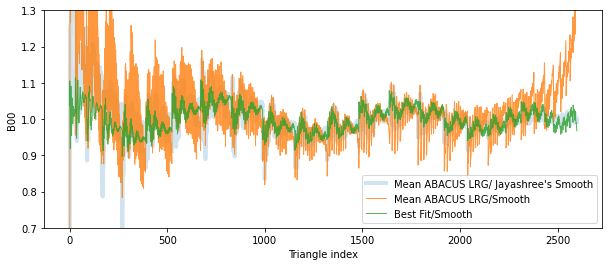

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(bs.b.mean(axis=0)/bs.b_smooth.mean(axis=0), label="Mean ABACUS LRG/ Jayashree's Smooth", alpha=0.2, lw=4)
plt.plot(bs.b.mean(axis=0)/tree_level_b00(*bs.k.T, *res.x, pknow_1d), label="Mean ABACUS LRG/Smooth", alpha=0.8, lw=1)
plt.plot(tree_level_b00(*bs.k.T, *res.x, pk)/tree_level_b00(*bs.k.T, *res.x, pknow_1d), alpha=0.8, label='Best Fit/Smooth', lw=1)
# plt.semilogy()
plt.ylim(0.7, 1.3)
plt.legend()
plt.xlabel('Triangle index')
plt.ylabel('B00')

In [ ]:
# 1. choose a power spectrum template that is close to ABACUS
#     1.2 try different set of CAMB parameters 
#

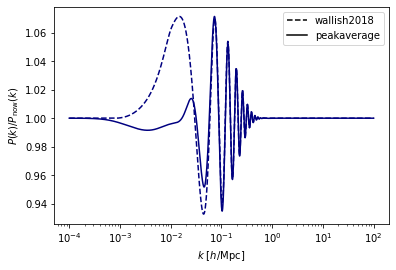

In [13]:
# Several engines are available for the power spectrum, but wallish2018 and peakaverage seem the most accurate one
# peakaverage has smooth dependence on cosmological parameters (useful for taking derivatives)
# Note one can also provide a 1D power spectrum interpolator
pknow_wallish = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()
pknow_brieden = PowerSpectrumBAOFilter(pk, engine='peakaverage', cosmo=cosmo, cosmo_fid=cosmo).smooth_pk_interpolator()
k = np.logspace(-4, 2, 10000)
z = [0.0, ]#, np.linspace(0., 4., 10)
colors = plt.cm.jet(np.linspace(0, 1, len(z)))
plt.plot([], [], linestyle='--', color='k', label='wallish2018')
plt.plot([], [], linestyle='-', color='k', label='peakaverage')
for zz, color in zip(z, colors):
    plt.plot(k, pk(k, z=zz) / pknow_wallish(k, z=zz), color=color, linestyle='--')
    plt.plot(k, pk(k, z=zz) / pknow_brieden(k, z=zz), color=color, linestyle='-')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)/P_{\mathrm{now}}(k)$')
#plt.xlim(, 1)
plt.xscale('log')
plt.legend()
plt.show()

[]

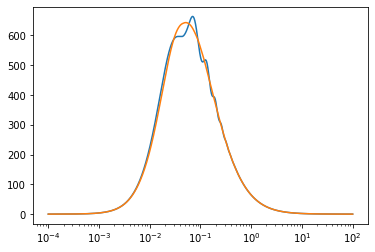

In [20]:
plt.plot(k, k*pk(k, z=zz))
plt.plot(k, k*pknow_wallish(k, z=zz))
plt.semilogx()

In [1]:
import numpy as np
import fftlog

In [2]:
import hankl

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from scipy.interpolate import interp1d

In [5]:
import camb

In [6]:
from camb import model, initialpower

In [7]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)

pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.0], kmax=2000)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)

In [8]:
k = np.logspace(-3, 3, 2**10)

In [9]:
PK = results.get_matter_power_interpolator(k_hunit=True)
pk = PK.P(0.0, k)#/1.42e2

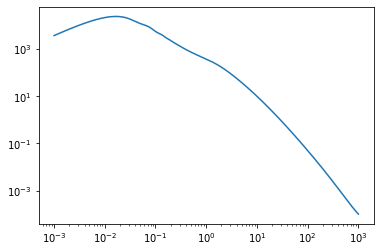

In [10]:
plt.loglog(k, pk)

In [11]:
r, xi = hankl.P2xi(k, pk, l=0)
xi = xi.real

In [88]:
def xi_model(r, p):
    return (p[0]*r*r + p[1]*r + p[6]*r*r*r)*np.exp(-r*r) + p[2]/r + p[3]/(r*r) + p[4] + p[5]/(r*r*r)

def loss(p, r, xi_obs):
    xi_m = xi_model(r, p)
    return ((xi_m - xi_obs)**2).sum()

In [13]:
from scipy.optimize import minimize

In [79]:
is_g = (r>20) & (r<50) 
is_g |= (r>150) & (r<200)

In [89]:
res = minimize(loss, [1., 1., 1., 1., 1., 1., 1., 1., 1.], args=(r[is_g], xi[is_g]))

(10.0, 400.0)

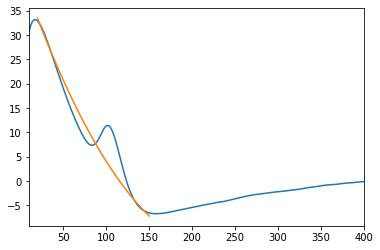

In [90]:
r_g = np.linspace(20, 150)
plt.plot(r, r**2*xi)
plt.plot(r_g, r_g**2*xi_model(r_g, res.x))
plt.xlim(10, 400)
# plt.ylim(-1, 2)